<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/KmeansRFMCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yellowbrick

###Exploração e Tratamento dos dados

Eliminados os clientes anônimos, assim como os dados duplicados e pedidos cancelados. Será trabalhado 73% (779495) do dataset.

DataFrameTotal: 1067371


####Valores faltantes:
Customer ID: Excluidos (243007)
Description: Substituidos por "No description" (4382)

Duplicados: Removidos (34335)

Cancelados: Removidos (19494)

####Outliers
Quantity: método do intervalo interquartil (IQR) para remover outliers extremos, eliminando valores abaixo do 25º percentil (Q1) e acima do 75º percentil (Q3).   

Price: método do intervalo interquartil para remoção.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from pyspark.sql.types import FloatType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

spark = SparkSession.builder.appName("ClusterCompras").getOrCreate()

df = spark.read.csv("online.csv", header=True, inferSchema=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
num_duplicates = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {num_duplicates}")
# Filtrar o DataFrame para obter apenas os valores de Invoice que começam com "C" (verificar o número de pedidos cancelados)
invoices_comecam_com_c = df.filter(col("Invoice").startswith("C"))
print(f"Number of canceled rows: {invoices_comecam_com_c}")

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371           |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233 |29011.161534536903|21848.

In [3]:
df.describe().show(truncate=False)

+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371           |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233 |29011.161534536903|21848.25                           |9.9388984711033   |4.649387727413342 |15324.63850435002 |NULL       |
|stddev |26662.450446905856|18822.94286618915 |922.9197780233488                  |172.70579407675524|123.55305872146378|1697.4644503793263|NULL       |
|min    |489434            |10002             |  DOORMAT UNION JACK GUNS AND ROSES

In [4]:
# preencher valores nulos na coluna Description
df = df.fillna({'Description': 'No description'})

# Excluir linhas onde Customer ID é nulo e duplicatas
df = df.filter(col("Customer ID").isNotNull()).dropDuplicates()

# Filtrar e excluir faturas que começam com 'C' (pedidos cancelados)
df = df.filter(~col("Invoice").startswith("C"))

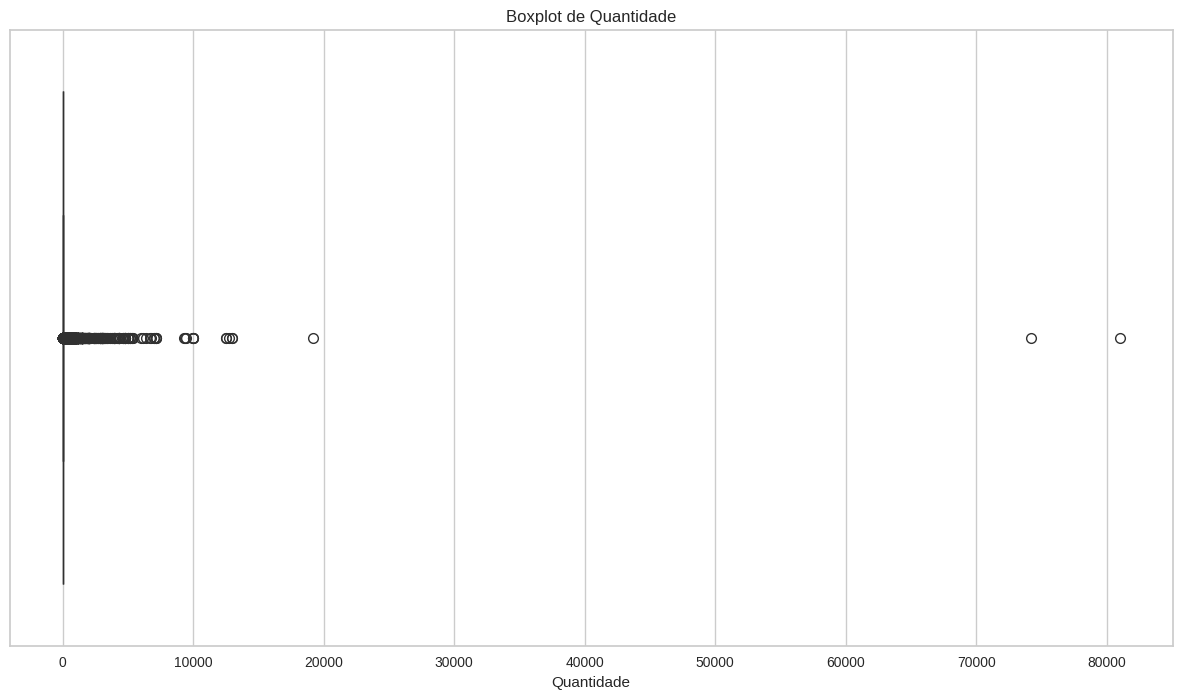

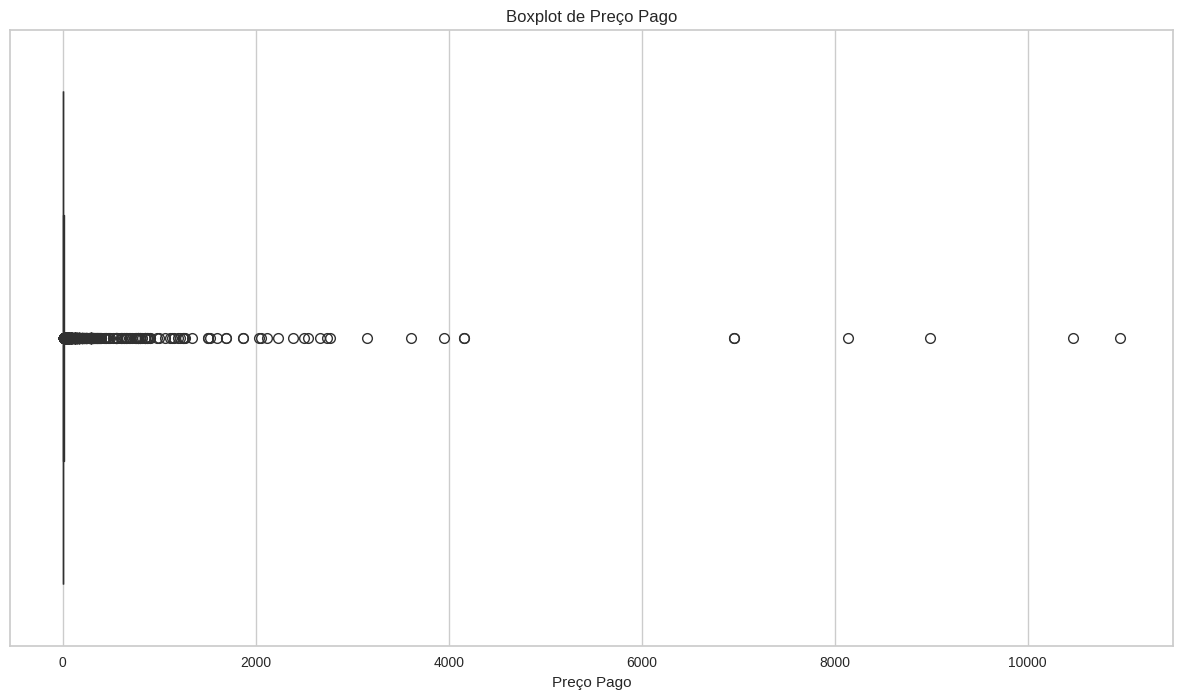

In [5]:
# Converter colunas "Quantity" e "Price" para DataFrames Pandas
quantity_pd = df.select("Quantity").toPandas()
price_pd = df.select("Price").toPandas()

# Boxplot de Quantidade
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_pd["Quantity"])
plt.title("Boxplot de Quantidade")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço Total Pago
plt.figure(figsize=(15, 8))
sns.boxplot(x=price_pd["Price"])
plt.title("Boxplot de Preço Pago")
plt.xlabel("Preço Pago")
plt.show()

In [6]:
# Definindo funções para remover outliers com base nos seus limites
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    num_outliers_above = dataframe[dataframe[variable] > up_limit].shape[0]
    num_outliers_below = dataframe[dataframe[variable] < low_limit].shape[0]
    # Convertendo os valores de outlier para tipo compatível antes de substituir
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit.astype(dataframe[variable].dtype)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit.astype(dataframe[variable].dtype)
    return num_outliers_above + num_outliers_below

# Contar o número de outliers antes de remover
num_outliers_quantity_before = quantity_pd[(quantity_pd["Quantity"] > outlier_thresholds(quantity_pd, "Quantity")[0]) |
                                           (quantity_pd["Quantity"] < outlier_thresholds(quantity_pd, "Quantity")[1])].shape[0]
num_outliers_price_before = price_pd[(price_pd["Price"] > outlier_thresholds(price_pd, "Price")[0]) |
                                     (price_pd["Price"] < outlier_thresholds(price_pd, "Price")[1])].shape[0]

print(f'Quantidade de outliers em Quantity antes: {num_outliers_quantity_before}')
print(f'Quantidade de outliers em Price antes: {num_outliers_price_before}')

Quantidade de outliers em Quantity antes: 1743
Quantidade de outliers em Price antes: 1361


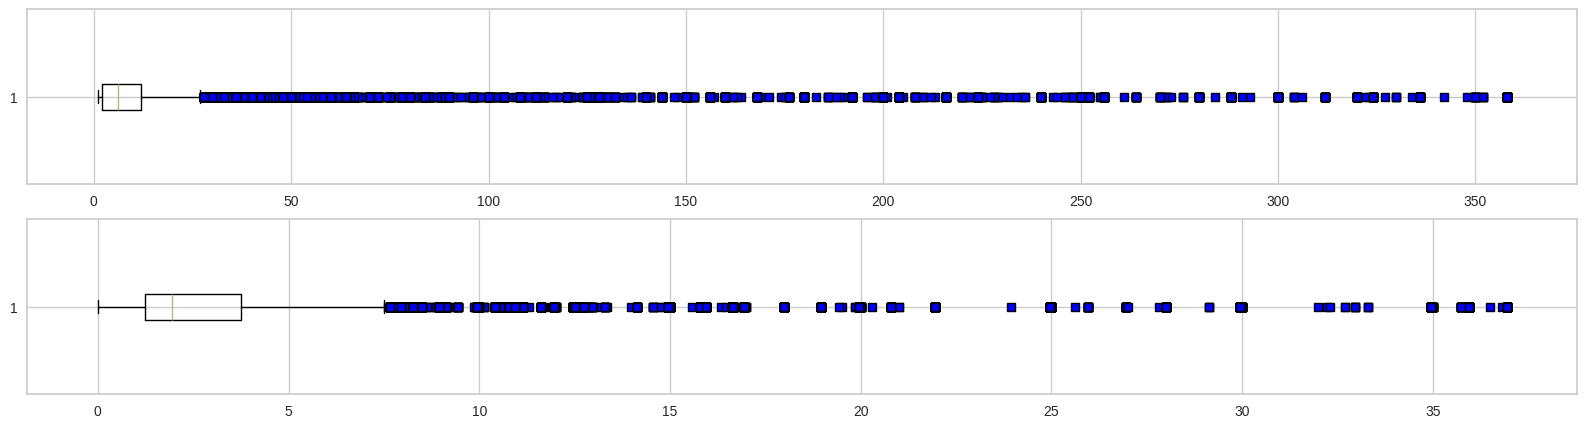

Quantidade de outliers em Quantity após: 0
Quantidade de outliers em Price após: 0


In [7]:
# Aplicando as funções para remover os outliers
num_outliers_quantity_removed = replace_with_threshold(quantity_pd, "Quantity")
num_outliers_price_removed = replace_with_threshold(price_pd, "Price")

# Atualizar os valores tratados no DataFrame Spark original
df = df.withColumn("Quantity", when(col("Quantity") > quantity_pd["Quantity"].max(), quantity_pd["Quantity"].max())
                   .when(col("Quantity") < quantity_pd["Quantity"].min(), quantity_pd["Quantity"].min())
                   .otherwise(col("Quantity")))

df = df.withColumn("Price", when(col("Price") > price_pd["Price"].max(), price_pd["Price"].max())
                   .when(col("Price") < price_pd["Price"].min(), price_pd["Price"].min())
                   .otherwise(col("Price")))

# Contar os outliers restantes para verificação
temp_df = df.select("Quantity", "Price").toPandas()
num_outliers_quantity_after = temp_df[(temp_df["Quantity"] > outlier_thresholds(temp_df, "Quantity")[0]) |
                                      (temp_df["Quantity"] < outlier_thresholds(temp_df, "Quantity")[1])].shape[0]
num_outliers_price_after = temp_df[(temp_df["Price"] > outlier_thresholds(temp_df, "Price")[0]) |
                                   (temp_df["Price"] < outlier_thresholds(temp_df, "Price")[1])].shape[0]

# Observando os dados após remover os outliers
col_list = ["Quantity", "Price"]
f, ax = plt.subplots(2, 1, figsize=(20, 5))
for i in range(2):
    ax[i].boxplot(temp_df[col_list[i]], flierprops=dict(marker="s", markerfacecolor="blue"), vert=0)
plt.show()

print(f'Quantidade de outliers em Quantity após: {num_outliers_quantity_after}')
print(f'Quantidade de outliers em Price após: {num_outliers_price_after}')

In [8]:
df.describe().show(truncate=False)

+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice           |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+------------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |779495            |779495            |779495                             |779495            |779495            |779495            |779495     |
|mean   |537427.0053906696 |28816.281876194367|NULL                               |12.10330662800916 |2.954198164191047 |15320.262917658227|NULL       |
|stddev |26901.961110083183|18512.15795650149 |NULL                               |28.117530560559626|3.2500027523649826|1695.7229879734768|NULL       |
|min    |489434            |10002             |  DOORMAT UNION JACK GUNS AND ROSES

### Engenharia de Recursos

####Variaveis selecionadas para o modelo:

Recency (Recência): Mede o tempo desde a última compra de um cliente. Exemplo: Se um cliente comprou pela última vez há 10 dias, a recência é 10.

Frequency (Frequência): Conta o número total de compras realizadas por um cliente. Exemplo: Se um cliente fez 15 compras, a frequência é 15.

Monetary (Monetário): Soma o total gasto pelo cliente em todas as compras. Exemplo: Se um cliente gastou R$ 500 no total, o valor monetário é 500.

Purchase Momentum (Impulso de Compra): Combina a frequência das compras com a recência, ponderando compras mais recentes de forma mais forte. Exemplo: Um cliente que fez 5 compras recentes terá um impulso de compra alto, indicando um comportamento de compra ativo e recente.

In [9]:
from pyspark.sql.window import Window

# Criar uma nova coluna 'Returns' que indica o número de devoluções
df = df.withColumn("Returns", when(col("Quantity") < 0, col("Quantity").cast("int") * -1).otherwise(0))

# Calcular TotalSpent
df = df.withColumn("TotalSpent", col("Quantity") * col("Price"))

# Adicionar a coluna do mês para medir a sazonalidade
df = df.withColumn("Month", month("InvoiceDate"))

# Calcular RFM e outras variáveis
agg_funcs = {
    "Recency": datediff(current_date(), max("InvoiceDate")).alias("Recency"),
    "Frequency": count("Invoice").alias("Frequency"),
    "Monetary": sum("TotalSpent").alias("Monetary"),
    "VarietyOfProducts": countDistinct("StockCode").alias("VarietyOfProducts"),
    "TotalReturns": sum("Returns").alias("TotalReturns"),
    "Shopping_Cycle": datediff(max("InvoiceDate"), min("InvoiceDate")).alias("Shopping_Cycle"),
    "Month": max("Month").alias("Month")
}

rfm_df = df.groupBy("Customer ID").agg(*agg_funcs.values())

# Calcular CLV
clv = df.groupBy("Customer ID").agg(sum("TotalSpent").alias("CLV"))
rfm_df = rfm_df.join(clv, "Customer ID", "left")

# Calcular Average Purchase Interval (API)
window_spec = Window.partitionBy("Customer ID").orderBy("InvoiceDate")
df = df.withColumn("PreviousPurchaseDate", lag("InvoiceDate").over(window_spec))
df = df.withColumn("PurchaseInterval", datediff(col("InvoiceDate"), col("PreviousPurchaseDate")))
api = df.groupBy("Customer ID").agg(avg("PurchaseInterval").alias("AveragePurchaseInterval"))
rfm_df = rfm_df.join(api, "Customer ID", "left")

# Calcular Purchase Momentum (PM)
# Precisamos de um DataFrame com Frequency e Recency
df_rfm_momentum = df.join(rfm_df.select("Customer ID", "Recency", "Frequency"), "Customer ID")

# Calcular Weighted Frequency
df_rfm_momentum = df_rfm_momentum.withColumn("WeightedFrequency", col("Frequency") / (1 + col("Recency")))

# Calcular Cumulative Momentum
window_spec_full = Window.partitionBy("Customer ID").orderBy("InvoiceDate").rowsBetween(Window.unboundedPreceding, 0)
df_rfm_momentum = df_rfm_momentum.withColumn("CumulativeMomentum", sum("WeightedFrequency").over(window_spec_full))

momentum = df_rfm_momentum.groupBy("Customer ID").agg(max("CumulativeMomentum").alias("PurchaseMomentum"))
rfm_df = rfm_df.join(momentum, "Customer ID", "left")
rfm_df = rfm_df.filter(col("Frequency") > 1)

# Selecionar colunas desejadas
rfmt_df = rfm_df.select("Recency", "Frequency", "Monetary", "PurchaseMomentum")
rfmt_df.show(5)

rfmt_pd = rfmt_df.toPandas()
#styled_df = rfmt_pd.head().style.set_properties(**{"background-color": "#cd5c5c", "color": "black", "border-color": "black"})
#styled_df

+-------+---------+------------------+-------------------+
|Recency|Frequency|          Monetary|   PurchaseMomentum|
+-------+---------+------------------+-------------------+
|   4774|      406|2698.4700000000016|  34.52062827225107|
|   4794|      205| 902.0199999999998|  8.764337851929055|
|   4792|       61|           3284.42| 0.7763404965574792|
|   5156|       29|            107.01|0.16307930967616835|
|   4781|      129| 658.9499999999998|  3.479924717691345|
+-------+---------+------------------+-------------------+
only showing top 5 rows



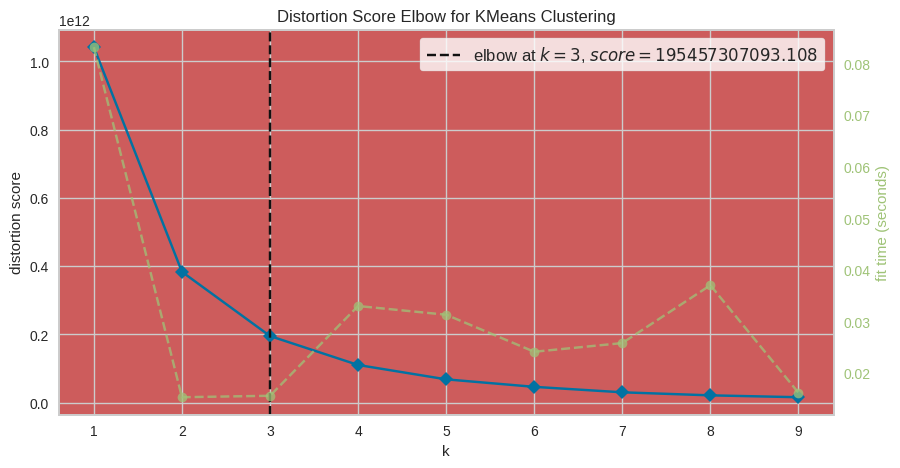

Therefore K = 3


In [10]:
from sklearn.cluster import KMeans
# Aplicar o método do cotovelo (Elbow Method) usando KElbowVisualizer
plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10), ax=ax)
visualizer.fit(rfmt_pd)
visualizer.show()

print("Therefore K =", visualizer.elbow_value_)

###Interpretação dos Clusters

Na representação dos clusters, a alta densidade dos dados indica comportamentos semelhantes de recency x frequency. Isso pode ser uma limitação da amostra, e uma amostra mais representativa ajustaria o modelo.


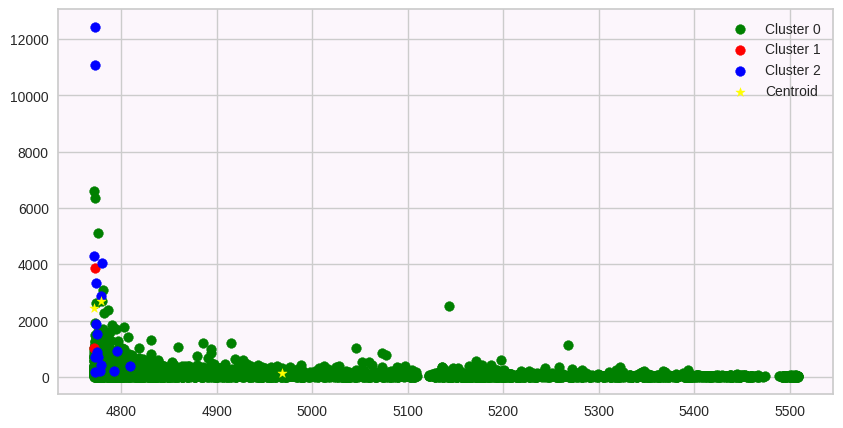

In [11]:
feature_cols = ["Recency", "Frequency", "Monetary", "PurchaseMomentum"]
X = rfmt_pd

# Treinar o modelo de KMeans
kmeans = KMeans(n_clusters=3, max_iter=50)
rfmt_pd['Clusters'] = kmeans.fit_predict(X)

one = rfmt_pd[rfmt_pd["Clusters"] == 0]
two = rfmt_pd[rfmt_pd["Clusters"] == 1]
three = rfmt_pd[rfmt_pd["Clusters"] == 2]
#four = rfmt_pd[rfmt_pd["Clusters"] == 3]

plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("#cd50c50c")
plt.scatter(one["Recency"], one["Frequency"], color='green', label="Cluster 0")
plt.scatter(two["Recency"], two["Frequency"], color='red', label="Cluster 1")
plt.scatter(three["Recency"], three["Frequency"], color='blue', label="Cluster 2")
#plt.scatter(four["Recency"], four["Frequency"], color='blue', label="Cluster 3")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="yellow", marker="*", label="Centroid")
plt.legend()
plt.show()


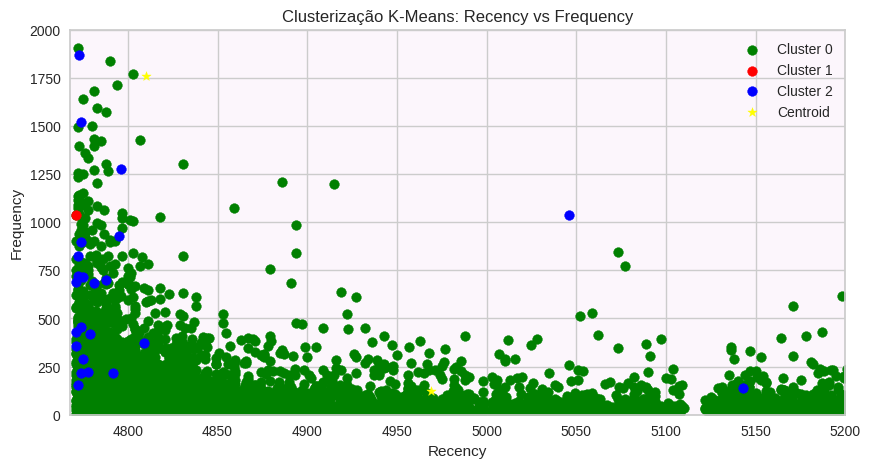

In [15]:
# Treinar o modelo de KMeans
kmeans = KMeans(n_clusters=3, max_iter=50)
rfmt_pd['Clusters'] = kmeans.fit_predict(X)

# Agrupar os dados de acordo com cada cluster
one = rfmt_pd[rfmt_pd["Clusters"] == 0]
two = rfmt_pd[rfmt_pd["Clusters"] == 1]
three = rfmt_pd[rfmt_pd["Clusters"] == 2]
#four = rfmt_pd[rfmt_pd["Clusters"] == 3]
#five = rfmt_pd[rfmt_pd["Clusters"] == 4]

# Definir limites dos eixos
max_recency = 5200
min_recency = 4768
max_frequency = 2000

# Visualizar os clusters com ajustes nos limites dos eixos
plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.set_facecolor("#cd50c50c")
plt.scatter(one["Recency"], one["Frequency"], color='green', label="Cluster 0")
plt.scatter(two["Recency"], two["Frequency"], color='red', label="Cluster 1")
plt.scatter(three["Recency"], three["Frequency"], color='blue', label="Cluster 2")
#plt.scatter(three["Recency"], three["Frequency"], color='orange', label="Cluster 3")
#plt.scatter(three["Recency"], three["Frequency"], color='pink', label="Cluster 4")

# Ajustar os limites dos eixos
plt.xlim([min_recency, max_recency])
plt.ylim([0, max_frequency])

# Adicionar os centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="yellow", marker="*", label="Centroid")
plt.legend()
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.title("Clusterização K-Means: Recency vs Frequency")
plt.show()


###Avaliação dos Clusters

Calinski-Harabasz Score para K-Means: 944.8102192086884. Este índice mede a densidade dos clusters e a separação entre eles. O valor alto sugere que os clusters estão bem definidos e que há uma boa separação entre eles.

Silhouette Score para K-Means: 0.9153026500838708. O Silhouette Score varia de -1 a 1. Valores próximos a 1 indicam que os pontos estão bem dentro dos clusters e bem separados de outros clusters. Um Silhouette Score de 0.905 é excepcional, indicando que os clusters são extremamente coesos e bem separados.

In [13]:
# Normalizar os dados
df_rfm_clip_scaled = (rfmt_pd[feature_cols] - rfmt_pd[feature_cols].mean()) / rfmt_pd[feature_cols].std()

# Calcular Calinski-Harabasz Score
ch_score_kmeans = calinski_harabasz_score(df_rfm_clip_scaled, rfmt_pd['Clusters'])
print(f'Calinski-Harabasz Score para K-Means: {ch_score_kmeans}')

# Calcular Silhouette Score
silhouette_score_kmeans = silhouette_score(df_rfm_clip_scaled, rfmt_pd['Clusters'])
print(f'Silhouette Score para K-Means: {silhouette_score_kmeans}')


Calinski-Harabasz Score para K-Means: 1163.926196437807
Silhouette Score para K-Means: 0.9153026500838708
